<a href="https://colab.research.google.com/github/aricahyasaputra/machine-learning-course-assigment/blob/main/Minggu%2012%20CNN%20part%202/Tugas_Minggu_12_GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GoogleNet

## Import Required Module(s)

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

# print(os.listdir("dataset/flowers"))

## CODE


The Flower Dataset can be acquired from the dataset folder in the repository

define Google Drive Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

baseDirectory = "/content/drive/My Drive/dataset/"

Mounted at /content/drive


In [ ]:
# define parameters

CLASS_NUM = 5
BATCH_SIZE = 16
EPOCH_STEPS = int(4323/BATCH_SIZE)
IMAGE_SHAPE = (224, 224, 3)
IMAGE_TRAIN = baseDirectory + 'flowers'
MODEL_NAME = 'googlenet_flower.h5'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

generator_main = train_datagen.flow_from_directory(
    IMAGE_TRAIN,
    target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 984 images belonging to 1 classes.


In [ ]:
def my_generator(generator):
    while True: # keras requires all generators to be infinite
        data = next(generator)
        x = data[0]
        y = data[1], data[1], data[1]
        yield x, y

In [ ]:
train_generator = my_generator(generator_main)

In [ ]:
# create model
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])

In [ ]:
def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=CLASS_NUM, activation='softmax', name=name)(layer)
    return layer

In [ ]:
def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=CLASS_NUM, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model

In [ ]:
# train model
model = googlenet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [ ]:
optimizer = ['Adam', 'SGD', 'Adam', 'SGD']
epochs = [20, 30, 20, 30]
history_all = {}

In [ ]:
for i in range(len(optimizer)):
    print('Usnig optimizer: ' + optimizer[i] + ', Epoch: ' + str(epochs[i]))
    
    model.compile(loss='categorical_crossentropy', 
                  loss_weights={'main': 1.0, 'aux1': 0.3, 'aux2': 0.3},
                  optimizer=optimizer[i], metrics=['accuracy'])
    
    train_history = model.fit_generator(
            train_generator,
            steps_per_epoch=EPOCH_STEPS,
            epochs=epochs[i],
            #callbacks=[checkpoint]
            shuffle=True
            )
    
    # save history    
    if len(history_all) == 0:
        history_all = {key: [] for key in train_history.history}
    
    for key in history_all:
        history_all[key].extend(train_history.history[key])

model.save(MODEL_NAME)

Usnig optimizer: Adam, Epoch: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/20
270/270 [==============================] - 84s 256ms/step - loss: nan - main_loss: nan - aux1_loss: nan - aux2_loss: nan - main_accuracy: 0.8729 - aux1_accuracy: 0.8995 - aux2_accuracy: 0.8678
Epoch 2/20
270/270 [==============================] - 68s 250ms/step - loss: nan - main_loss: nan - aux1_loss: nan - aux2_loss: nan - main_accuracy: 1.0000 - aux1_accuracy: 1.0000 - aux2_accuracy: 1.0000
Epoch 3/20
270/270 [==============================] - 68s 251ms/step - loss: nan - main_loss: nan - aux1_loss: nan - aux2_loss: nan - main_accuracy: 1.0000 - aux1_accuracy: 1.0000 - aux2_accuracy: 1.0000
Epoch 4/20
270/270 [==============================] - 68s 252ms/step - loss: nan - main_loss: nan - aux1_loss: nan - aux2_loss: nan - main_accuracy: 1.0000 - aux1_accuracy: 1.0000 - aux2_accuracy: 1.0000
Epoch 5/20
270/270 [==============================] - 68s 250ms/step - loss: nan - main_loss: nan - aux1_loss: nan - aux2_loss: nan - main_accuracy: 1.0000 - aux1_accuracy: 1.0000 - au

In [ ]:
# show train history
def show_train_history(history, xlabel, ylabel, train):
    for item in train:
        plt.plot(history[item])
    plt.title('Train History')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(train, loc='upper left')
    plt.show()

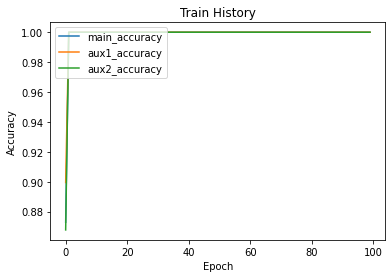

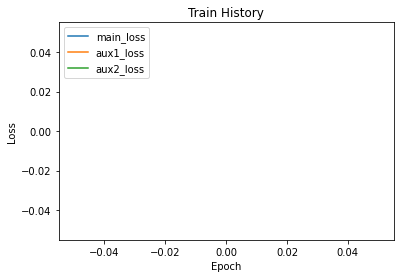

In [ ]:
show_train_history(history_all, 'Epoch', 'Accuracy', ('main_accuracy', 'aux1_accuracy', 'aux2_accuracy'))
show_train_history(history_all, 'Epoch', 'Loss', ('main_loss', 'aux1_loss', 'aux2_loss'))